In [1]:
from utils.clustering import Cluster
from utils.data_loader import load_data, yearly_data_as_timeseries
from utils.magic import log_time, set_r_python_seed
import rpy2.robjects as ro

from utils.models import Model
from utils.results import Analyse, ModelPerformance, YearlyPerformance

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import numpy as np

from utils.visualize import YearlyClustering, _n_colors, plot_clustering, trace_plots

/home/dinae/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# PLOTTING -> LaTeX
use_tex = True
if use_tex:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif", size="16")

In [3]:
priors = {
# params as stated in the original drpm paper of page et al.
"paper_params": {
    # modelPriors: m0, s20, A_sigma, A_tau, A_lambda, b_e (xi)
    "modelPriors": ro.FloatVector([0, 100**2, 10, 5, 5, 1]),
    # modelPriors: a_alpha, b_alpha -> most mass on the value of 0.5
    "alphaPriors": ro.r["matrix"](ro.FloatVector([2.0, 2.0]), nrow=1),
    "SpatialCohesion": 3,
    "spatial": False,
},
# tuned params
"lower_std": {
    # A_sigma is way smaller => smaller clusters in general
    # A_tau, A_lambda also smaller to set incentives for smaller clusters
    "modelPriors": ro.FloatVector([0, 100 * 2, 0.1, 1, 1, 1]),
    "alphaPriors": ro.r["matrix"](ro.FloatVector([1.0, 1.0]), nrow=1),
    "SpatialCohesion": 4,
    "spatial": False,
},
"mean_prev_year": {
    # A_sigma is way smaller => smaller clusters in general
    # A_tau, A_lambda also smaller to set incentives for smaller clusters
    # use the mean of log(val_2018 + 1): 2.909599862036403 as a mean prior
    "modelPriors": ro.FloatVector([2.91, 100 * 2, 0.1, 1, 1, 1]),
    # uniform prior
    "alphaPriors": ro.r["matrix"](ro.FloatVector([1.0, 1.0]), nrow=1),
    "SpatialCohesion": 4,
    "spatial": False
},
"paper_params_spatial": {
    # modelPriors: m0, s20, A_sigma, A_tau, A_lambda, b_e (xi)
    "modelPriors": ro.FloatVector([0, 100**2, 10, 5, 5, 1]),
    # modelPriors: a_alpha, b_alpha -> most mass on the value of 0.5
    "alphaPriors": ro.r["matrix"](ro.FloatVector([2.0, 2.0]), nrow=1),
    "SpatialCohesion": 3,
    "spatial": True,
},
# tuned params
"lower_std_spatial": {
    # A_sigma is way smaller => smaller clusters in general
    # A_tau, A_lambda also smaller to set incentives for smaller clusters
    "modelPriors": ro.FloatVector([0, 100 * 2, 0.1, 1, 1, 1]),
    "alphaPriors": ro.r["matrix"](ro.FloatVector([1.0, 1.0]), nrow=1),
    "SpatialCohesion": 4,
    "spatial": True,
},
"mean_prev_year_spatial": {
    # A_sigma is way smaller => smaller clusters in general
    # A_tau, A_lambda also smaller to set incentives for smaller clusters
    # use the mean of log(val_2018 + 1): 2.909599862036403 as a mean prior
    "modelPriors": ro.FloatVector([2.91, 100 * 2, 0.1, 1, 1, 1]),
    # uniform prior
    "alphaPriors": ro.r["matrix"](ro.FloatVector([1.0, 1.0]), nrow=1),
    "SpatialCohesion": 4,
    "spatial": True
},
}


set_r_python_seed()
data = load_data()
pm25_timeseries = yearly_data_as_timeseries(data)
salso_args = {"loss": "binder", "maxNCluster": 0}
all_results: list[ModelPerformance] = []

# for prior in priors.keys():
for prior in ["paper_params", "lower_std", "mean_prev_year",
"paper_params_spatial","lower_std_spatial","mean_prev_year_spatial"]:
    print(prior)
    drpm_args = {
        "M": 0.1,
        "starting_alpha": 0.5,
        "unit_specific_alpha": False,  # diff alpha for each station --> prior needs to be adjusted
        "time_specific_alpha": True,  # diff alpha is drawn for each time-step
        "alpha_0": False,
        # True for conditionally independence
        "eta1_0": True,
        "phi1_0": True,
        "modelPriors": priors[prior]["modelPriors"],
        "alphaPriors": priors[prior]["alphaPriors"],
        "simpleModel": 0,
        "theta_tau2": ro.FloatVector([0, 2]),  # only use with simpleModel=True
        "SpatialCohesion": priors[prior]["SpatialCohesion"],
        # cohesionPrior: mu0, k0, v0, L0
        "cParms": ro.FloatVector([0, 1, 2, 1]),
        # params for metropolis updates: sigma2, tau, lambda, eta1, phi1
        "mh": ro.FloatVector([0.5, 1, 0.1, 0.1, 0.1]),
        "verbose": False,
        "draws": 10000,
        "burn": 1000,
        "thin": 10,
    }
    model = Model("drpm", drpm_args, uses_weekly_data=False)

    model_result = ModelPerformance(name=model.name)

    it = 1
    for model_params in model.yield_test_cases():
        print("==========================")
        print("\nCASE {}/{}\n".format(it, model.num_experiments))
        print("==========================")
        # use yearly data
        model_args = model_params | model.load_model_specific_data(
            data=data, yearly_time_series=pm25_timeseries, model_params=model_params,
            spatial = priors[prior]["spatial"]
        )
        res_cluster, time_needed = Cluster.cluster(model=model.name, **model_args)
        yearly_result = YearlyPerformance(
            config=model_params,
            yearly_result_decomposed=Analyse.analyze_yearly_performance(
                py_res=res_cluster,
                target=pm25_timeseries,
                time_needed=time_needed,
                salso_args=salso_args,
            ),
        )
        save_to_visualize_cluster = YearlyClustering(
            yearly_decomposed_result=yearly_result, data=data
        )
        # trace_plots(res_cluster, model=model.name)
        model_result.add_testcase(yearly_result=yearly_result)
        it += 1
    all_results.append(model_result)

2023-12-13 09:54:12.794 WARNING: R[write to console]: In addition: 
2023-12-13 09:54:12.796 WARNING: R[write to console]: Warning messages:

2023-12-13 09:54:12.798 WARNING: R[write to console]: 1: 
2023-12-13 09:54:12.802 WARNING: R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
2023-12-13 09:54:12.804 WARNING: R[write to console]: 
 
2023-12-13 09:54:12.805 WARNING: R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

2023-12-13 09:54:12.806 WARNING: R[write to console]: 2: 
2023-12-13 09:54:12.808 WARNING: R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
2023-12-13 09:54:12.809 WARNING: R[write to console]: 
 
2023-12-13 09:54:12.811 WARNING: R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

2023-12-13 09:54:12.812 WARNING: R[write to console]: 3: 
2023-12-13 09:54:12.813 WARNING: R[write to console]: In (function (package, he

paper_params

CASE 1/1

sPPM =  FALSE 
ntime =  52 
ntime_out =  52 
nsubject = 34
ntime = 52
nout = 900
update_alpha = 1
update_eta1 = 0
update_phi1 = 0
Prior values: Asig = 10.00, Atau = 5.00, Alam = 5.00, 
 m0 = 0.00, s20 = 10000.00

mcmc iter = 10000 =========================================== 
Wed Dec 13 09:54:36 2023
ntime =  52 
ntime_out =  52 


2023-12-13 09:54:37.018 INFO: cluster took 24.0870s


lower_std

CASE 1/1

sPPM =  FALSE 
ntime =  52 
ntime_out =  52 
nsubject = 34
ntime = 52
nout = 900
update_alpha = 1
update_eta1 = 0
update_phi1 = 0
Prior values: Asig = 0.10, Atau = 1.00, Alam = 1.00, 
 m0 = 0.00, s20 = 200.00

mcmc iter = 10000 =========================================== 
Wed Dec 13 09:58:06 2023
ntime =  52 
ntime_out =  52 


2023-12-13 09:58:06.576 INFO: cluster took 207.7219s


mean_prev_year

CASE 1/1

sPPM =  FALSE 
ntime =  52 
ntime_out =  52 
nsubject = 34
ntime = 52
nout = 900
update_alpha = 1
update_eta1 = 0
update_phi1 = 0
Prior values: Asig = 0.10, Atau = 1.00, Alam = 1.00, 
 m0 = 2.91, s20 = 200.00

mcmc iter = 10000 =========================================== 
Wed Dec 13 10:00:35 2023
ntime =  52 
ntime_out =  52 


2023-12-13 10:00:35.665 INFO: cluster took 146.5794s


paper_params_spatial

CASE 1/1

sPPM =  TRUE 
ntime =  52 
ntime_out =  52 
nsubject = 34
ntime = 52
nout = 900
update_alpha = 1
update_eta1 = 0
update_phi1 = 0
Prior values: Asig = 10.00, Atau = 5.00, Alam = 5.00, 
 m0 = 0.00, s20 = 10000.00

mu0
0.000000 0.000000 

k0 = 1.000000
v0 = 2.000000
L0
1.000000 0.000000 
0.000000 1.000000 

mcmc iter = 10000 =========================================== 
Wed Dec 13 10:01:22 2023
ntime =  52 
ntime_out =  52 


2023-12-13 10:01:22.159 INFO: cluster took 43.8404s


lower_std_spatial

CASE 1/1

sPPM =  TRUE 
ntime =  52 
ntime_out =  52 
nsubject = 34
ntime = 52
nout = 900
update_alpha = 1
update_eta1 = 0
update_phi1 = 0
Prior values: Asig = 0.10, Atau = 1.00, Alam = 1.00, 
 m0 = 0.00, s20 = 200.00

mu0
0.000000 0.000000 

k0 = 1.000000
v0 = 2.000000
L0
1.000000 0.000000 
0.000000 1.000000 

mcmc iter = 10000 =========================================== 
Wed Dec 13 10:08:44 2023
ntime =  52 
ntime_out =  52 


2023-12-13 10:08:44.871 INFO: cluster took 440.9488s


mean_prev_year_spatial

CASE 1/1

sPPM =  TRUE 
ntime =  52 
ntime_out =  52 
nsubject = 34
ntime = 52
nout = 900
update_alpha = 1
update_eta1 = 0
update_phi1 = 0
Prior values: Asig = 0.10, Atau = 1.00, Alam = 1.00, 
 m0 = 2.91, s20 = 200.00

mu0
0.000000 0.000000 

k0 = 1.000000
v0 = 2.000000
L0
1.000000 0.000000 
0.000000 1.000000 

mcmc iter = 10000 =========================================== 
Wed Dec 13 10:16:43 2023
ntime =  52 
ntime_out =  52 


2023-12-13 10:16:43.592 INFO: cluster took 476.0030s


/tmp/ipykernel_21176/333958228.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+[str(i*10+1) for i in range(0,weeks)])
/tmp/ipykernel_21176/333958228.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+[str(weeks-i*10-1) for i in range(0,weeks)])
/tmp/ipykernel_21176/333958228.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+[str(i*10+1) for i in range(0,weeks)])
/tmp/ipykernel_21176/333958228.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+[str(weeks-i*10-1) for i in range(0,weeks)])
/tmp/ipykernel_21176/333958228.py:26: UserWarning: set_ticklabel

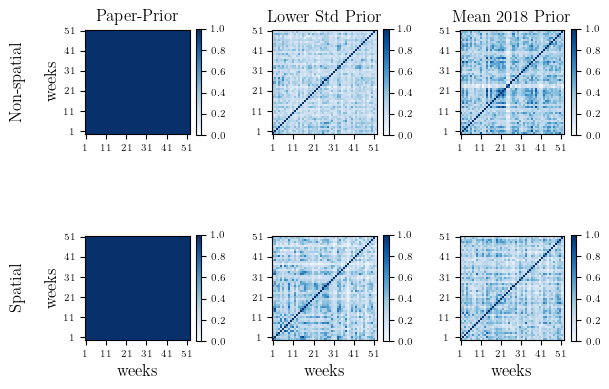

In [36]:
def plot_laggedARI(
    ncols: int,
    nrows: int,
    labels: str,
    all_results: list[ModelPerformance],
    filename: str = "drpm_laggedARI",
    title: str = "",
    weeks: int = 5,
    adjusted: bool = True
):
    if adjusted:
        key = "laggedARI"
    else:
        key = "laggedRI"

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)


    for i, ax in enumerate(fig.axes):
        model = all_results[i]
        mat = ax.matshow(model.test_cases[0].list_of_weekly[key][0:weeks,0:weeks][::-1,:],
                            cmap ='Blues',
                            vmin=0,
                            vmax=1)

        ax.set_xticklabels(['']+[str(i*10+1) for i in range(0,weeks)])
        ax.set_yticklabels(['']+[str(weeks-i*10-1) for i in range(0,weeks)])
        ax.xaxis.tick_bottom()
        ax.tick_params(labelsize=7)

        cbar = fig.colorbar(mat, ax=ax, shrink =0.5)
        cbar.ax.tick_params(labelsize=7)

        if i== 0:
            ax.set_ylabel('Non-spatial\n \nweeks', fontdict = {'size':12})
        
        if i == ncols:
            ax.set_ylabel('Spatial\n\nweeks', fontdict={'size':12})

        if i >= (nrows-1)*ncols:
            ax.set_xlabel('weeks', fontdict={'size':12})

        if i < ncols:
            ax.set_title(labels[i], fontsize = 12)

    plt.tight_layout()
    plt.savefig("../report/imgs/drpm/{}.pdf".format(filename))
    plt.savefig("../report/imgs/drpm/{}.pdf".format(filename))




plot_laggedARI(
        ncols = 3,
        nrows = 2,
        labels = ['Paper-Prior', 'Lower Std Prior','Mean 2018 Prior'],
        all_results = all_results,
        filename="drpm_laggedARI",
        title = "Lagged ARI for Cluster Estimates",
        weeks = 52,
        adjusted = True
    )